In [1]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [2]:
create_experiment_snapshots([25, 50, 75, 100])

In [3]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = 100
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
trial = 10


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RadarPlot:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, total_nodes, new_network, features, model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.mtd_interval = mtd_interval
        self.schemes = ['simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.features = features
        self.model = model
        self.trial = trial
        self.normalization_values = {scheme: self.calculate_normalized_values(scheme) for scheme in self.schemes}





    def calculate_normalized_values(self, scheme):
        # DataFrame to store the results of each trial
        security_metrics = pd.DataFrame(columns=self.features)

        for _ in range(self.trial):
            # Execute the AI model and collect the results
            evaluation = execute_ai_model(
                model=self.model, 
                features=self.features, 
                start_time=self.start_time, 
                finish_time=self.finish_time, 
                mtd_interval=self.mtd_interval, 
                scheme=scheme, 
                total_nodes=self.total_nodes, 
                new_network=self.new_network
            )
            # Extract the latest security metrics record
            security_metrics_trial = evaluation.security_metrics_record.get_record().drop('times', axis=1).iloc[-1]
            security_metrics = pd.concat([security_metrics, pd.DataFrame([security_metrics_trial])], ignore_index=True)

        # Calculate median for normalization
        normalized_values = security_metrics.median().to_dict()

        return normalized_values
    
    def compute_metrics(self, normalization_values=None):
            # DataFrame to store the results of each trial
            security_metrics = pd.DataFrame(columns=self.features)

            for _ in range(self.trial):
                # Execute the AI model and collect the results
                evaluation = execute_ai_model(
                    model=self.model,
                    features=self.features,
                    start_time=self.start_time,
                    finish_time=self.finish_time,
                    mtd_interval=self.mtd_interval,
                    scheme='mtd_ai',
                    total_nodes=self.total_nodes,
                    new_network=self.new_network
                )
                # Extract the latest security metrics record
                security_metrics_trial = evaluation.security_metrics_record.get_record().drop('times', axis=1).iloc[-1]
                security_metrics = pd.concat([security_metrics, pd.DataFrame([security_metrics_trial])], ignore_index=True)

            # Normalize each column if normalization values are provided
            if normalization_values:
                for column, norm_value in normalization_values.items():
                    if column in security_metrics.columns:
                        if column in ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure", "risk"]:
                            security_metrics[column] = 1 / (security_metrics[column] / norm_value)
                        else:
                            security_metrics[column] = security_metrics[column] / norm_value

            # Calculate median and standard deviation for each metric
            results = {
                'Median': security_metrics.median(),
                'Standard Deviation': security_metrics.std()
            }

            # Convert results to a DataFrame
            results_security_metrics = pd.DataFrame(results).dropna()

            # Extract data for the radar plot
            metrics_values = results_security_metrics['Median'].tolist()
            labels = results_security_metrics.index.tolist()

            return labels, metrics_values, results_security_metrics['Standard Deviation'].tolist()
    

    def plot_radar(self, labels, metrics_values, std_dev_values, scheme):
        # Number of metrics
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        metrics_values += metrics_values[:1]
        std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, metrics_values, color='blue', alpha=0.25)
        ax.plot(angles, metrics_values, color='blue', linewidth=2, label='Median')

        # Add error bars
        for i in range(num_vars):
            angle = angles[i]
            value = metrics_values[i]
            error = std_dev_values[i]
            ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = metrics_values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.title(f"Radar chart with AI with all 4 single MTD (compare to {scheme}) over {self.trial} trials", size=15, color='blue', y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()


    def plot_stacked_radar(self, metrics_data, scheme_names):
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Define colors for each scheme
        colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']

        for i, (labels, metrics_values, std_dev_values) in enumerate(metrics_data):
            num_vars = len(labels)
            angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle
            metrics_values += metrics_values[:1]
            std_dev_values += std_dev_values[:1]
            labels += labels[:1]

            ax.fill(angles, metrics_values, color=colors[i % len(colors)], alpha=0.25)
            ax.plot(angles, metrics_values, color=colors[i % len(colors)], linewidth=2, label=scheme_names[i])

            for j in range(num_vars):
                angle = angles[j]
                value = metrics_values[j]
                error = std_dev_values[j]
                ax.errorbar(angle, value, yerr=error, fmt='o', color=colors[i % len(colors)], capsize=5, elinewidth=2)

            for j in range(num_vars):
                angle = angles[j]
                value = metrics_values[j]
                ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.title(f"Stacked Radar Chart for Multiple Schemes against AI over {self.trial} trials", size=15, color='black', y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()

    def plot_against_all_schemes(self):
        metrics_data = []
        for scheme in self.schemes:
            labels, metrics_values, std_dev_values = self.compute_metrics(normalization_values=self.normalization_values[scheme])
            metrics_data.append((labels, metrics_values, std_dev_values))
        
        self.plot_stacked_radar(metrics_data, self.schemes)

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metri

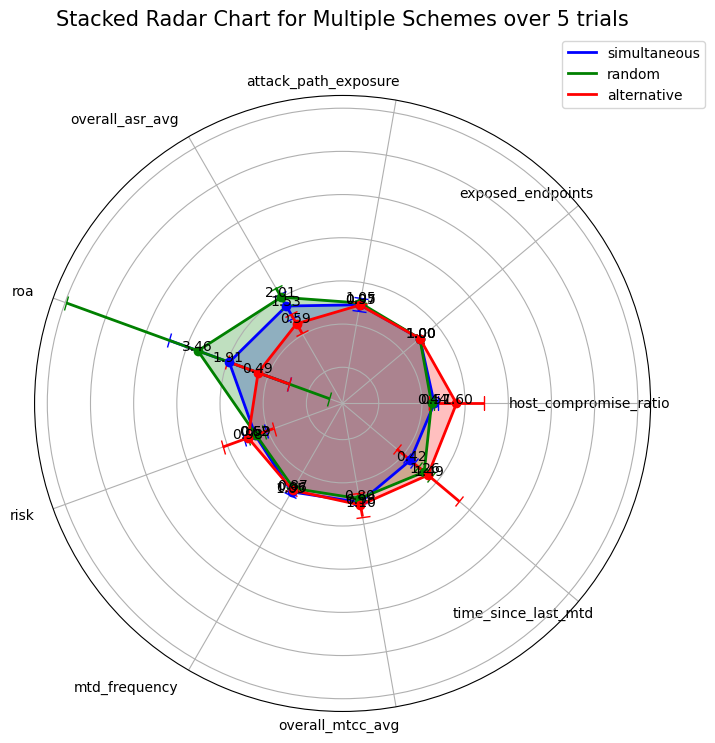

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metri

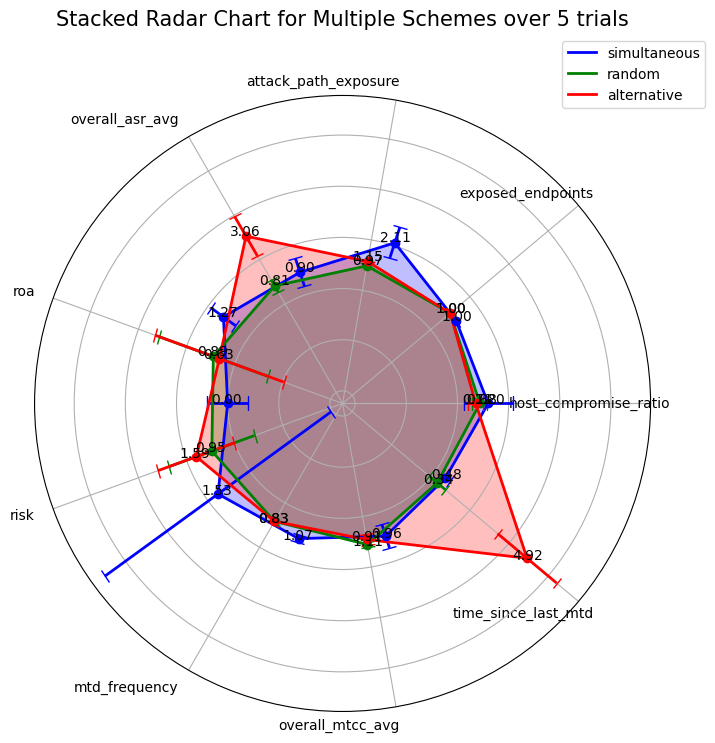

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metri

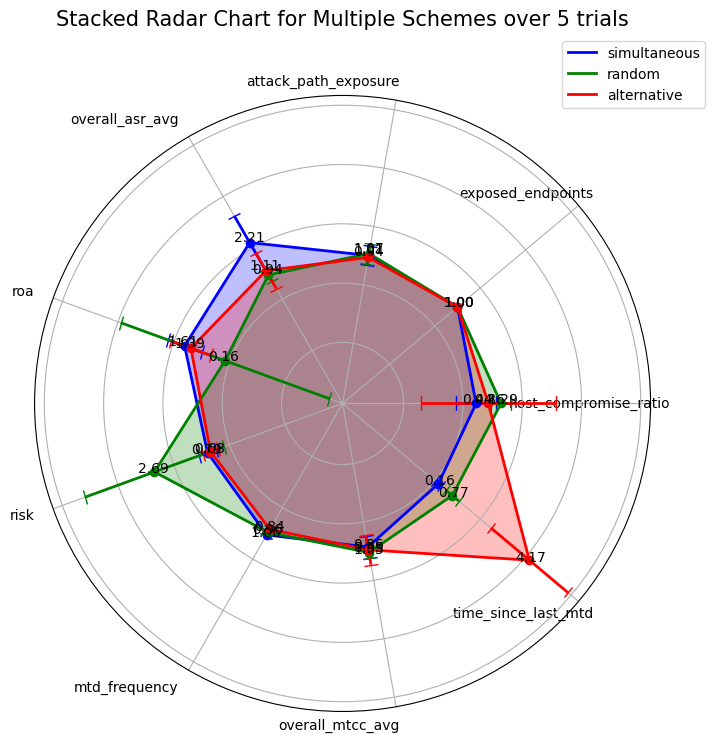

In [21]:
models =  ["main_network_all_features", "main_network_attack_path_exposure", "main_network_exposed_endpoints"]

for model in models:
    radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, total_nodes, new_network, features, model, 5)
    # Plot against all schemes
    radar.plot_against_all_schemes()

